<h2> Pattern Classification Using Adaline Networks</h2>

In [785]:
import numpy as np
import copy
from termcolor import colored
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os

In [786]:
image_path = "./AdalineResources/images/"

Initialize input and target vectors

In [1100]:
s = np.array(([1,1,-1],[1,2,-1],[2,-1,1],[2,0,1],[1,-2,1],[0,0,1],[-1,2,1],[-2,1,1],[-1,-1,-1],[-2,-2,-1],[-2,-1,-1]))

In [1101]:
targets = np.array(([-1,-1],[-1,-1],[-1,1],[-1,1],[-1,1],[-1,1],[1,-1],[1,-1],[1,1],[1,1],[1,1]))

In [1102]:
assert s.shape[0] == targets.shape[0], 'Number of inputs are equal'
print("Input Shape: {}, output shape: {}".format(s.shape,targets.shape))


Input Shape: (11, 3), output shape: (11, 2)


In [1103]:
#Transpose the shapes of input and targets
s = s.T
targets = targets.T
assert s.shape[1] == targets.shape[1], 'Number of inputs are unequal'
print("Input Shape: {}, output shape: {}".format(s.shape,targets.shape))
targets

Input Shape: (3, 11), output shape: (2, 11)


array([[-1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1],
       [-1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1]])

In [1104]:
#Initializing test data
test_s = copy.copy(s)
test_target = copy.copy(targets)

<b> Define dimensions for Adaline Network </b>


In [1105]:
layer_dim = [s.shape[0],targets.shape[0]]
total_samples = s.shape[1]

In [1106]:
def plot_learning_curve(data,alpha,save_to_file=False):
    fig = plt.figure()
    ax=plt.gca()
    lists = sorted(data.items())
    x,y = zip(*lists)
    plt.plot(x,y)
    plt.title('Learning Curve_{}'.format(alpha))
    plt.xlabel('learning_rate')
    plt.ylabel('accuracy')
    
    
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text= "alpha={:.4f}, accuracy={:.3f}".format(xmax, ymax*100)
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)
    
    if save_to_file == True:
        fig.savefig(image_path+"alpha_"+alpha+".png")
        
    plt.show()

In [1107]:
def plot_error_curve(data,alpha,save_to_file=False):

    fig = plt.figure()
    ax=plt.gca()
    lists = sorted(data.items())
    x,y = zip(*lists)
    plt.plot(x,y,c='r')
    plt.title('Error Curve_{}'.format(alpha))
    plt.xlabel('learning_rate')
    plt.ylabel('error')
    
    
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text= "alpha={}, error={:.3f}".format(xmin, ymin)
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.96), **kw)
    
    if save_to_file == True:
        fig.savefig(image_path+"error_"+alpha+".png")
        
    plt.show()

In [1108]:
def compute_learning_rate(iterations,learning_rate,useIterations=True):
    if useIterations == True:
        learning_rate =  learning_rate/(total_samples*iterations)
    else:
        learning_rate =  learning_rate/(total_samples)

    return float("{0:.10f}".format(learning_rate))


<b> Helper Functions for Adaline Network </b>

In [1109]:
def _checkInputRange(start,end):
    if start > end:
        start = 0
    return start

<b> Build Adaline Network </b>

In [1216]:
class AdalineNetwork:
    parameters = {}
    
    def __init__(self):
        self.parameters["W"] = np.zeros([layer_dim[0],layer_dim[1]])
        self.parameters["b"] = np.zeros([layer_dim[1],1])
        
        assert self.parameters["W"].shape[1] == self.parameters["b"].shape[0],"Weight and bias are of incorrect dimensions"
        print("Model Initialized with shapes, Weight Matrix {}, Bias Vectcor {}".format(self.parameters["W"].shape,self.parameters["b"].shape))
        
        assert not np.any(self.parameters["W"]) == True,"Weight matrix is not initilaized to zero"
        assert not np.any(self.parameters["b"]) == True,"Bias vector is not initilaized to zero"
        
        
    def affineForward(self,S,W,b):
        S = S.reshape(-1,3)
        yin = np.dot(S,W).reshape(2,-1)
        yin = yin+b
        #print('affine forward--yin,S,W,b',yin,S,W,b)
        return yin
        
    
    def activationForward(self,yin,theta=0):
        yin[yin>=theta] = 1
        yin[yin<theta] = -1
        yin = yin.astype(int)
        return yin

    def feedForwardPropagation(self, S, activation=True,theta=0):
        W = self.parameters["W"]
        b = self.parameters["b"]
        yin = self.affineForward(S,W,b)
        
        if activation == False:
            return yin
        else:
            y = self.activationForward(yin,theta=0)
            print('activation',y)
            return y
    
    def error_function(self,yin,target):
        #print('Error Function')
        yin = yin.reshape(2,-1)
        target = target.reshape(2,-1)
        #print(yin,target)
        #print(yin.shape,target.shape)
        error = np.subtract(yin,target)
        #print(error)
        error = error**2
        error = np.sum(error,axis=0)
        #print('error',error)
        return error
    
    def affineBackward(self,X,y,t):
        t = t.reshape(-1,2)
        y = y.reshape(-1,2)
        X = X.reshape(-1,3)
        err = np.subtract(y,t)
        dw = np.dot(X.T,err)
        db = err.T
        return dw,db
        
    
    def backwardPropagation(self,X,y,t,alpha):
        #print('Initiating backward Propagation')
        dw,db = self.affineBackward(X,y,t)
        dw = 2*alpha*dw
        db = 2*alpha*db
        #print('backwardprop dw,db',dw,db)
        return dw,db
        
    def updateParameters(self,dw,db):
        #print(dw.shape,db.shape)
        self.parameters["W"] = np.subtract(self.parameters["W"],dw)
        self.parameters["b"] = np.subtract(self.parameters["b"],db)
        #print('Update W',self.parameters["W"],self.parameters["b"])
        
    def accuracy(self,yin,target):
        yin_copy = copy.copy(yin)
        y = self.activationForward(yin_copy)
        y = y.reshape(-1,2)
        #print(y,target,y.shape,target.shape)
        
        if np.array_equal(y[0],target):          
            #print(colored('Yes convergence for the vectors predicted,target--> {} {}'.format(y[0],target),'green'))
            pass
        else:
            #print(colored ('No convergence for the vectors predicted,target--> {} {}'.format(y[0],target),'red'))
            pass
        
        return y[0],target
        
    def train(self,s,targets,iterations,learning_rate,is_variable_input=False):
       
        batch_error=[];
        prediction_y = [];
        target_t = [];
        
        if (iterations < s.shape[1]):
            iterations = s.shape[1]
        
        print('Model Training for total iterations of: {} at learning_rate: {}'.format(iterations,learning_rate))
        s_start = 0
        s_end = s.shape[1]-1
        batch = 1;
        
        if is_variable_input==True:
            test_data = s[:,7][0]
            print('Training for input s8 changed to {}'.format(s[:,7]))
            
        for i in range(0,iterations):
            #print('Starting iteration: {}...'.format(i))
            
            s_start = _checkInputRange(s_start,s_end)
            yin = self.feedForwardPropagation(s[:,s_start],activation=False)
            y,t = self.accuracy(yin,targets[:,s_start])
            
            prediction_y.append(list(y))
            target_t.append(list(t))
            
            error = self.error_function(yin,targets[:,s_start])
            #error = self.error_function(y,t)
            batch_error.append(error[0])
            
            if s_start == s_end:
                err_sum = sum(batch_error)/(s_end+1)
                #print(colored('Error observed at the end of batch size: {} is :{}'.format(s_end+1,err_sum),'red'))
                
                score = accuracy_score(np.array(prediction_y),np.array(target_t))
                #print(colored('Accuracy observed for the batch of training set: {0:.2f}'.format(score*100),'blue'))
                
                if batch == 1:
                    regularization_dict[learning_rate] = score
                    batch = batch+1
                    
                if is_variable_input==True:
                    variable_input_dict[test_data]=score
                    error_dict[test_data]=err_sum
                    
                elif is_variable_input==None:
                    error_dict[i]=err_sum
                
                else: 
                    error_dict[learning_rate]=err_sum
                    
                prediction_y.clear()
                target_t.clear()
                batch_error.clear()
                
                #print('*******************************************************************************')
                
            dw,db = self.backwardPropagation(s[:,s_start],yin,targets[:,s_start],learning_rate)
            self.updateParameters(dw,db)
            s_start = s_start+1
            
        
        print('.........Training concludes here!...........')
    
    def predict(self,s,theta=0):
        print('Running Predictions on input...')
        y = self.feedForwardPropagation(s,activation=True,theta=0)      
        return y
            
            
            
            
            

<b>Find the best learning_rate</b>

In [1217]:
regularization_dict = {}
error_dict = {}
iterations=22

for i in range(1,10):
    model = AdalineNetwork()
    alpha = float("{0:.10f}".format(i/10))
    learning_rate = compute_learning_rate(iterations,learning_rate=alpha,useIterations=False)
    model.train(s,targets,iterations,learning_rate=learning_rate)

Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0090909091
.........Training concludes here!...........
Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0181818182
.........Training concludes here!...........
Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0272727273
.........Training concludes here!...........
Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0363636364
.........Training concludes here!...........
Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0454545455
.........Training concludes here!...........
Model Initialized with shapes, Weight Ma

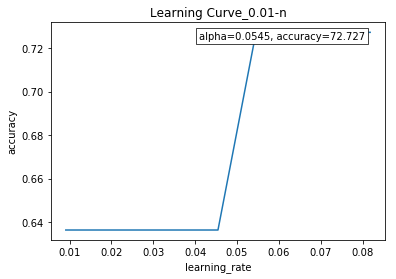

In [1218]:
alpha = "0.01-n"
plot_learning_curve(regularization_dict,alpha,save_to_file=True)
#plot_error_curve(error_dict,'error'+alpha,save_to_file=True)


<b>Using the optimal regularization parameters for training again </b>

In [1219]:
iterations=22
learning_rate = 0.0545
for i in range(1,10,1):
    model = AdalineNetwork()
    learning_rate = learning_rate+(i/1000)
    model.train(test_s,test_target,iterations,learning_rate=learning_rate)
    



Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0555
.........Training concludes here!...........
Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0575
.........Training concludes here!...........
Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.060500000000000005
.........Training concludes here!...........
Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0645
.........Training concludes here!...........
Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0695
.........Training concludes here!...........
Model Initialized with shapes, Weight Matrix (3, 2), Bia

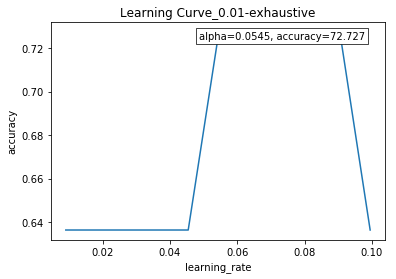

In [1220]:
alpha = "0.01-exhaustive"
plot_learning_curve(regularization_dict,alpha,save_to_file=True)
#plot_error_curve(error_dict,alpha,save_to_file=True)

<b>Train Model with best learning_rate </b>

In [1221]:
iterations=22
learning_rate = 0.0555
model = AdalineNetwork()
model.train(test_s,test_target,iterations,learning_rate=learning_rate)


Model Initialized with shapes, Weight Matrix (3, 2), Bias Vectcor (2, 1)
Model Training for total iterations of: 22 at learning_rate: 0.0555
.........Training concludes here!...........


<b>Plotting Error trends for best convergence</b>

In [1222]:
regularization_dict = {}
error_dict = {}
iterations=1000
learning_rate = 0.055
model.train(test_s,test_target,iterations,learning_rate=learning_rate,is_variable_input=None)


Model Training for total iterations of: 1000 at learning_rate: 0.055
.........Training concludes here!...........


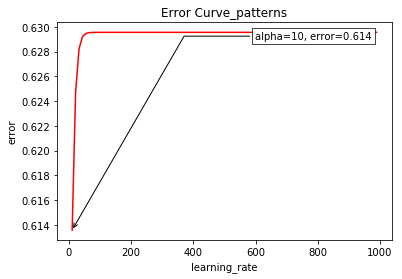

In [1223]:
label = "patterns"
plot_error_curve(error_dict,label,save_to_file=False)


<b>Test for various patterns in the training set </b>

In [1212]:
iterations=1
learning_rate = 0.055
variable_input_dict={}
error_dict = {}
for i in range(-2,10,1):
    s_new = copy.copy(s)
    s_new[:,7][0]=i
    model.train(s_new,targets,iterations,learning_rate=learning_rate,is_variable_input=True)


Model Training for total iterations of: 11 at learning_rate: 0.055
Training for input s8 changed to [-2  1  1]
Error observed at the end of batch size: 11 is :0.6195311390655583
Accuracy observed for the batch of training set: 100.00
*******************************************************************************
.........Training concludes here...........
Model Training for total iterations of: 11 at learning_rate: 0.055
Training for input s8 changed to [-1  1  1]
Error observed at the end of batch size: 11 is :0.6319126834983352
Accuracy observed for the batch of training set: 100.00
*******************************************************************************
.........Training concludes here...........
Model Training for total iterations of: 11 at learning_rate: 0.055
Training for input s8 changed to [0 1 1]
Error observed at the end of batch size: 11 is :0.7511983866491918
Accuracy observed for the batch of training set: 100.00
*****************************************************

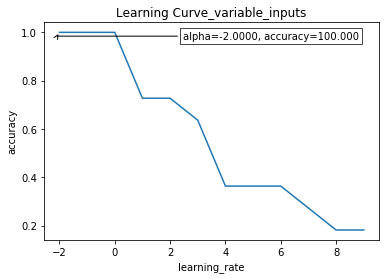

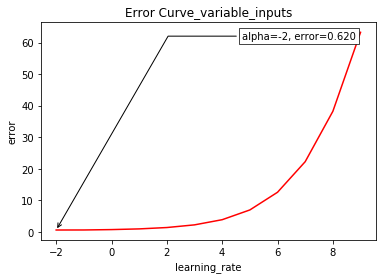

In [1213]:
alpha = "variable_inputs"
plot_learning_curve(variable_input_dict,alpha,save_to_file=True)
plot_error_curve(error_dict,alpha,save_to_file=True)


In [1215]:
#Reset the dictionary values
regularization_dict={}
error_dict = {}